### Predicting the sales of products across stores of a retail chain

In [1]:
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import itertools
import warnings
import numpy as np

warnings.filterwarnings("ignore")

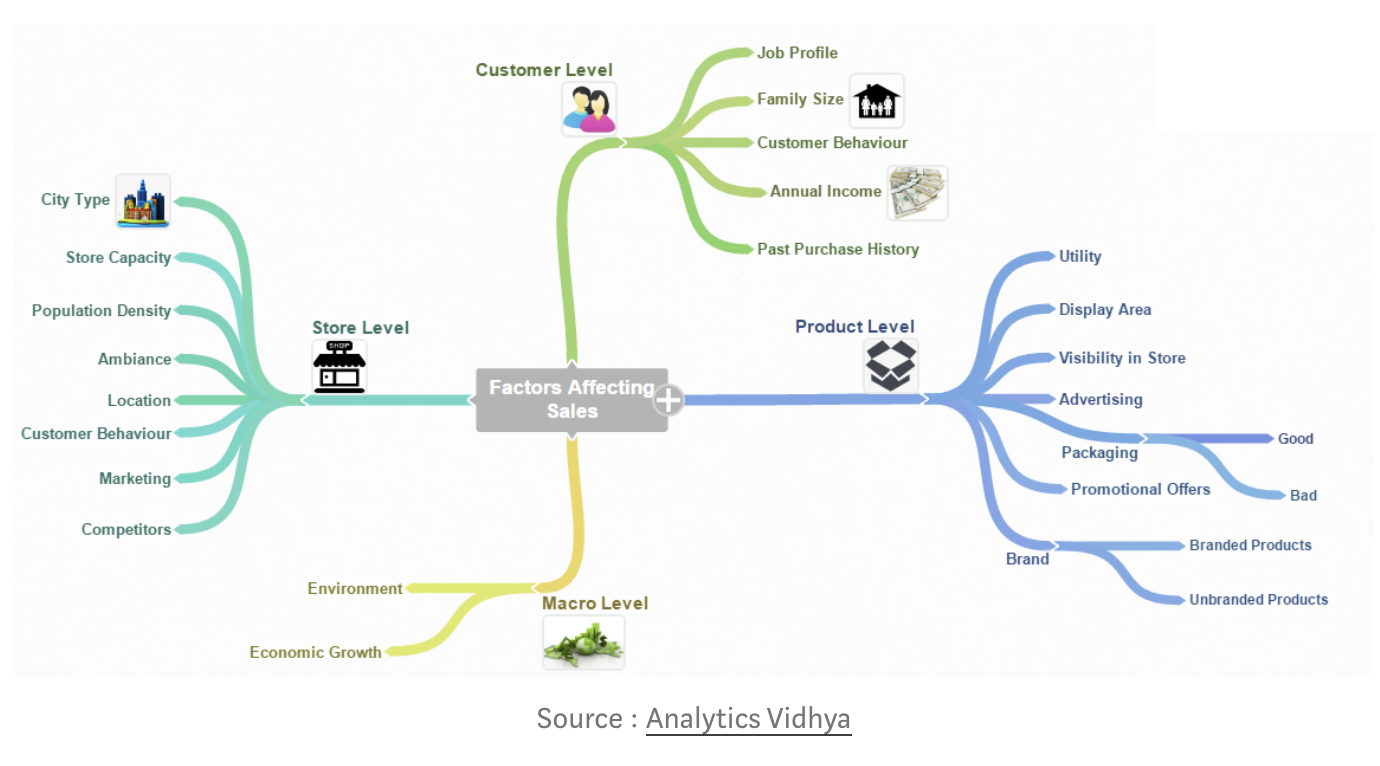

In [2]:
Image(filename='sales_factors.png') 

###### Above figure is only to understand the impact of available variables

In [3]:
# Read train and test files
train_raw = pd.read_csv('train_data.csv')
test_raw = pd.read_csv('test_data.csv')

In [4]:
train_raw.head()

date  product_identifier  department_identifier  \
0  01/01/12                  74                     11   
1  01/01/12                 337                     11   
2  01/01/12                 423                     12   
3  01/01/12                 432                     12   
4  01/01/12                 581                     21   

          category_of_product  outlet        state  sales  
0                      others     111  Maharashtra      0  
1                      others     111  Maharashtra      1  
2                      others     111  Maharashtra      0  
3                      others     111  Maharashtra      0  
4  fast_moving_consumer_goods     111  Maharashtra      0

In [5]:
print(train_raw.dtypes)
train_raw['date'] = pd.to_datetime(train_raw['date'], infer_datetime_format=True)
print(train_raw.dtypes)

date                     object
product_identifier        int64
department_identifier     int64
category_of_product      object
outlet                    int64
state                    object
sales                     int64
dtype: object
date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product              object
outlet                            int64
state                            object
sales                             int64
dtype: object


In [6]:
test_raw.head()

id        date  product_identifier  department_identifier  \
0   1  2014-03-01                  74                     11   
1   2  2014-03-01                 337                     11   
2   3  2014-03-01                 423                     12   
3   4  2014-03-01                 432                     12   
4   5  2014-03-01                 581                     21   

          category_of_product  outlet        state  
0                      others     111  Maharashtra  
1                      others     111  Maharashtra  
2                      others     111  Maharashtra  
3                      others     111  Maharashtra  
4  fast_moving_consumer_goods     111  Maharashtra

In [7]:
print(test_raw.dtypes)
test_raw['date'] = pd.to_datetime(test_raw['date'], infer_datetime_format=True)
print(test_raw.dtypes)

id                        int64
date                     object
product_identifier        int64
department_identifier     int64
category_of_product      object
outlet                    int64
state                    object
dtype: object
id                                int64
date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product              object
outlet                            int64
state                            object
dtype: object


###### From the first look of the data, my belief is that, the variables that will have higher impact on the sales are category_of_product, state and outlet

In [8]:
train_raw.shape

(395000, 7)

In [9]:
train_raw['category_of_product'].unique()

array(['others', 'fast_moving_consumer_goods', 'drinks_and_food'],
      dtype=object)

#### There are several categories in the retail chain sales data, we start from time series analysis and forecasting for fast_moving_consumer_goods sales.

In [10]:
FMCG = train_raw.loc[train_raw['category_of_product'] == 'fast_moving_consumer_goods']
print(FMCG.dtypes)
FMCG['date'].min(), FMCG['date'].max()

date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product              object
outlet                            int64
state                            object
sales                             int64
dtype: object


(Timestamp('2012-01-01 00:00:00'), Timestamp('2014-12-02 00:00:00'))

#### we have a good two years of data for our analysis

In [11]:
FMCG.head(10)

date  product_identifier  department_identifier  \
4  2012-01-01                 581                     21   
5  2012-01-01                 611                     21   
6  2012-01-01                 631                     21   
7  2012-01-01                 659                     21   
8  2012-01-01                 743                     21   
9  2012-01-01                 797                     21   
10 2012-01-01                 868                     21   
11 2012-01-01                 904                     21   
12 2012-01-01                 926                     21   
13 2012-01-01                 972                     21   

           category_of_product  outlet        state  sales  
4   fast_moving_consumer_goods     111  Maharashtra      0  
5   fast_moving_consumer_goods     111  Maharashtra      0  
6   fast_moving_consumer_goods     111  Maharashtra      0  
7   fast_moving_consumer_goods     111  Maharashtra      0  
8   fast_moving_consumer_goods     111  Maharashtra      0  
9   fast_moving_consumer_goods     111  Maharashtra      0  
10  fast_moving_consumer_goods     111  Maharashtra      1  
11  fast_moving_consumer_goods     111  Maharashtra      0  
12  fast_moving_consumer_goods     111  Maharashtra      0  
13  fast_moving_consumer_goods     111  Maharashtra      0

In [12]:
FMCG.tail(10)

date  product_identifier  department_identifier  \
394973 2014-02-28                1275                     22   
394974 2014-02-28                1322                     22   
394975 2014-02-28                1328                     22   
394976 2014-02-28                1365                     22   
394977 2014-02-28                1424                     22   
394978 2014-02-28                1472                     22   
394979 2014-02-28                1508                     22   
394980 2014-02-28                1542                     22   
394981 2014-02-28                1548                     22   
394982 2014-02-28                1599                     22   

               category_of_product  outlet   state  sales  
394973  fast_moving_consumer_goods     333  Kerala      0  
394974  fast_moving_consumer_goods     333  Kerala      0  
394975  fast_moving_consumer_goods     333  Kerala      1  
394976  fast_moving_consumer_goods     333  Kerala      0  
394977  fast_moving_consumer_goods     333  Kerala      2  
394978  fast_moving_consumer_goods     333  Kerala      1  
394979  fast_moving_consumer_goods     333  Kerala      0  
394980  fast_moving_consumer_goods     333  Kerala      0  
394981  fast_moving_consumer_goods     333  Kerala      0  
394982  fast_moving_consumer_goods     333  Kerala      0

# Data Processing

###### This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [13]:
cols = ['product_identifier', 'department_identifier',
       'category_of_product', 'outlet', 'state']

In [14]:
FMCG.isnull().sum()

date                     0
product_identifier       0
department_identifier    0
category_of_product      0
outlet                   0
state                    0
sales                    0
dtype: int64

In [15]:
FMCG = FMCG.drop(cols, axis=1)
FMCG.head()

date  sales
4 2012-01-01      0
5 2012-01-01      0
6 2012-01-01      0
7 2012-01-01      0
8 2012-01-01      0

In [16]:
FMCG = FMCG.sort_values('date')
FMCG.head()

date  sales
4   2012-01-01      0
327 2012-01-01      0
326 2012-01-01      0
325 2012-01-01      0
324 2012-01-01      1

In [17]:
FMCG = FMCG.groupby('date')['sales'].sum().reset_index()
FMCG.head()

date  sales
0 2012-01-01    144
1 2012-01-02    172
2 2012-01-03    221
3 2012-01-04    277
4 2012-01-05    226

## Indexing with time series data

In [18]:
FMCG = FMCG.set_index('date')
FMCG.head()

sales
date             
2012-01-01    144
2012-01-02    172
2012-01-03    221
2012-01-04    277
2012-01-05    226

In [19]:
FMCG.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2014-08-01', '2014-08-02', '2014-09-01', '2014-09-02',
               '2014-10-01', '2014-10-02', '2014-11-01', '2014-11-02',
               '2014-12-01', '2014-12-02'],
              dtype='datetime64[ns]', name='date', length=790, freq=None)

###### Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [20]:
y = FMCG['sales'].resample('MS').mean()

In [21]:
y

date
2012-01-01    207.354839
2012-02-01    203.517241
2012-03-01    205.387097
2012-04-01    204.533333
2012-05-01    206.483871
2012-06-01    230.066667
2012-07-01    230.354839
2012-08-01    223.096774
2012-09-01    197.966667
2012-10-01    200.354839
2012-11-01    192.933333
2012-12-01    180.387097
2013-01-01    173.806452
2013-02-01    189.821429
2013-03-01    176.935484
2013-04-01    166.533333
2013-05-01    182.225806
2013-06-01    195.033333
2013-07-01    187.225806
2013-08-01    192.870968
2013-09-01    192.566667
2013-10-01    171.516129
2013-11-01    153.800000
2013-12-01    155.387097
2014-01-01    151.190476
2014-02-01    183.555556
2014-03-01    163.000000
2014-04-01    163.500000
2014-05-01    168.500000
2014-06-01    120.000000
2014-07-01    143.000000
2014-08-01    203.000000
2014-09-01    199.000000
2014-10-01    150.000000
2014-11-01    208.500000
2014-12-01    188.500000
Freq: MS, Name: sales, dtype: float64

In [22]:
## Have a quick peek 2012 sales data.
y['2014':]

date
2014-01-01    151.190476
2014-02-01    183.555556
2014-03-01    163.000000
2014-04-01    163.500000
2014-05-01    168.500000
2014-06-01    120.000000
2014-07-01    143.000000
2014-08-01    203.000000
2014-09-01    199.000000
2014-10-01    150.000000
2014-11-01    208.500000
2014-12-01    188.500000
Freq: MS, Name: sales, dtype: float64

## Visualizing FMCG sales time series data

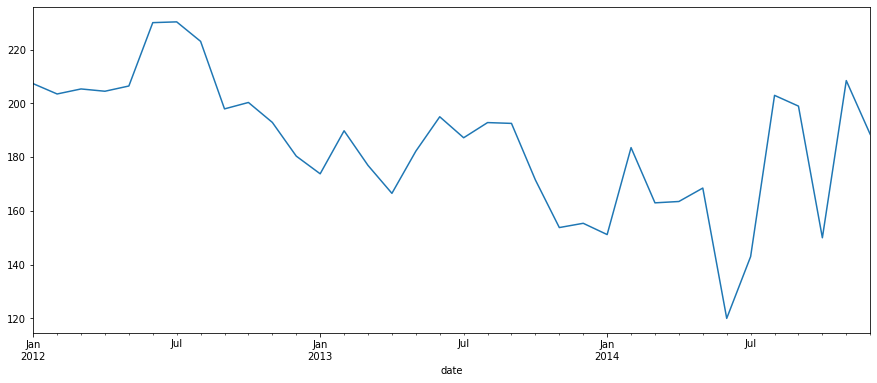

In [23]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are high at the beginning of the year and also relatively high at the end of the year. 

There is ALWAYS a slightly DOWNWARD trend within any single year also with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

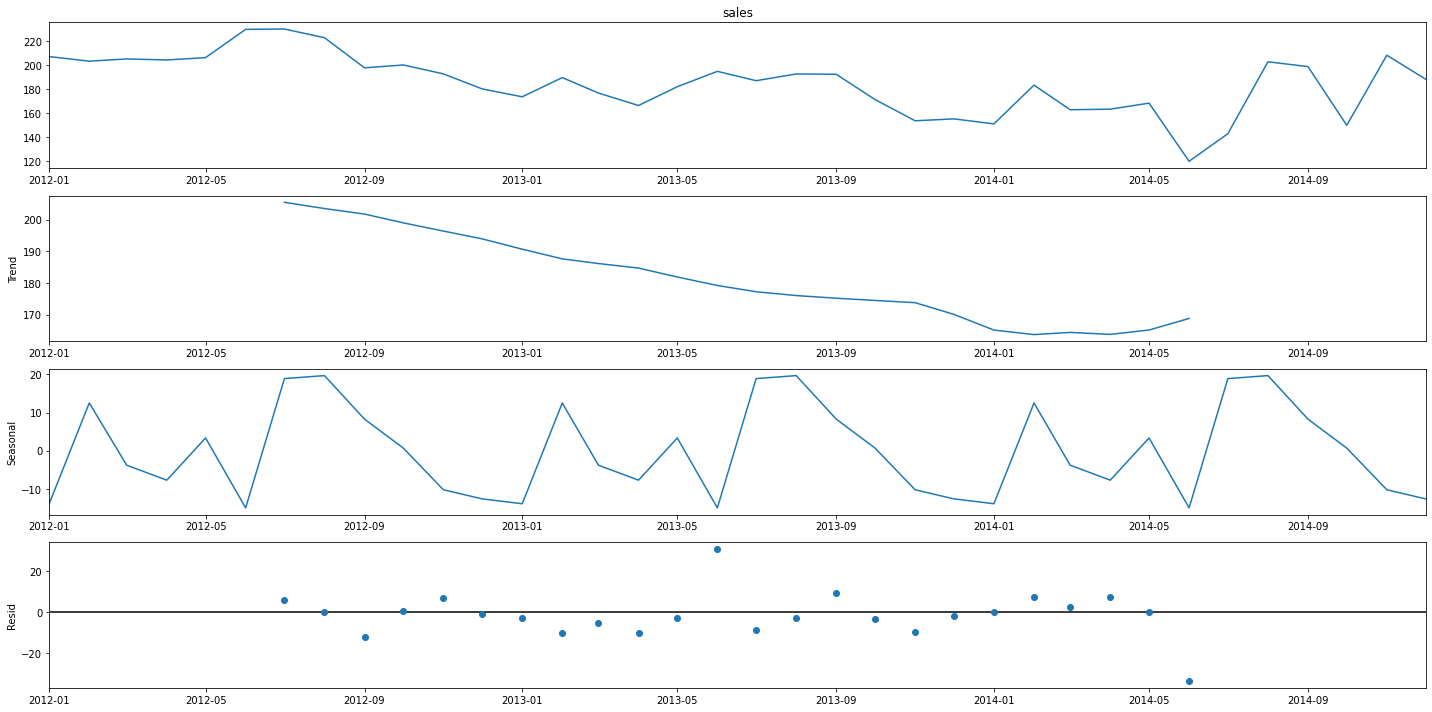

In [24]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 10

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit(maxiter=200)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:467.1441262299769
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:294.91972361670037
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:226.41971727057205
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:112.10799825988254
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:226.4353693956762
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:219.83187389398623
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:121.05171508853107
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:114.10323746032654
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:413.9073280078718
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:258.5666853339444
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:209.32041485185724
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:102.82752310469728
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:222.78185860816484
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:213.43248609668677
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:120.5233824415281
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:104.71510119535398
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:310.84147523504424
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:211.057671364710

In [27]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# with optimization routine (e.g. nm for Nelder-Mead):
results = mod.fit(maxiter=1000, method='nm')

print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 1.379945
         Iterations: 230
         Function evaluations: 382
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3625      1.472      0.246      0.805      -2.522       3.247
ma.L1         -0.8484      0.855     -0.992      0.321      -2.524       0.827
ar.S.L12       0.0009      1.818      0.001      1.000      -3.562       3.563
sigma2      1207.3833    586.235      2.060      0.039      58.384    2356.382


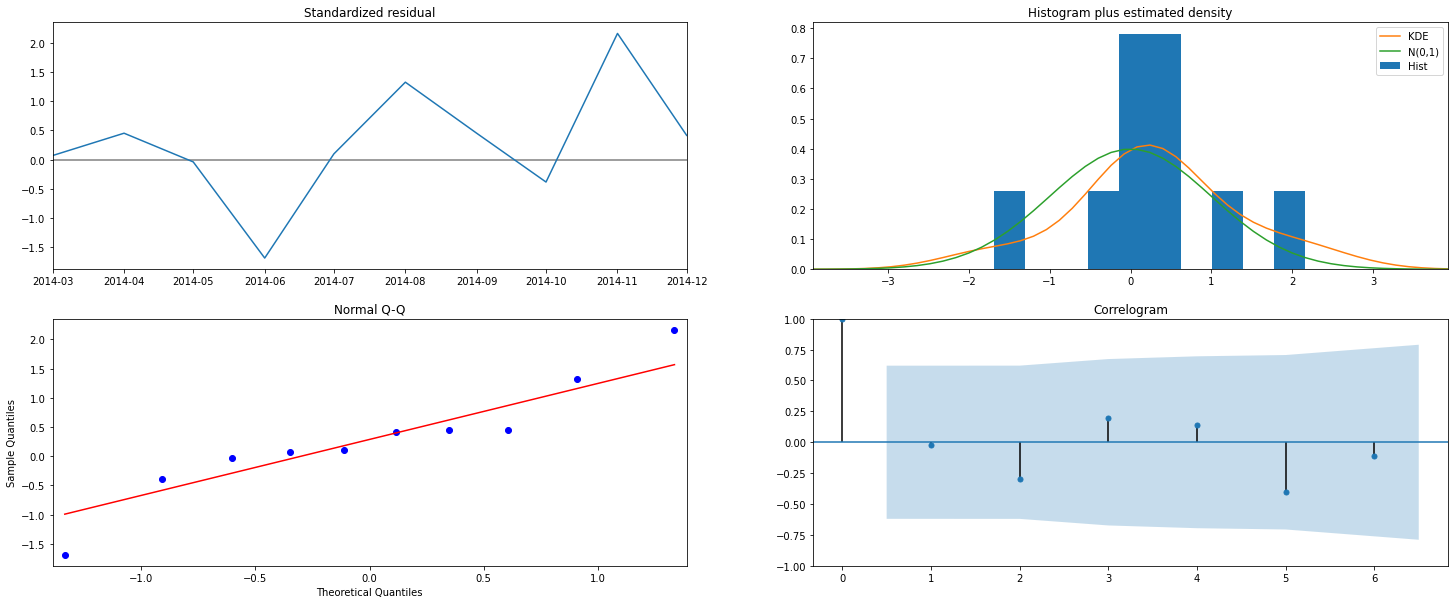

In [28]:
results.plot_diagnostics(lags=6,figsize=(25,10))
plt.show() 

Note to moderator: There's an ongoing bug in plot_diagnostics. Please refer to https://github.com/statsmodels/statsmodels/issues/6173

I had to religiously use 'lags' param to get corellogram as a workaround

## Validating forecasts (RMSE)

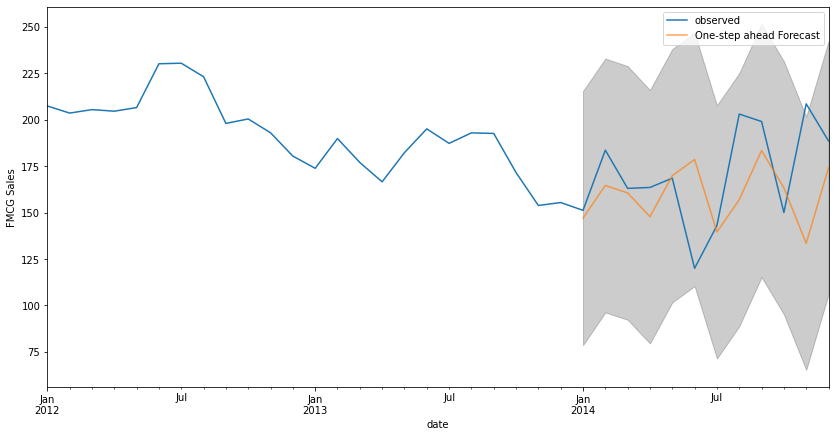

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('date')
ax.set_ylabel('FMCG Sales')
plt.legend()

plt.show()


The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [30]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1038.59


In [31]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 32.23


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily FMCG sales in the test set within 151.64 of the real sales. Our FMCG daily sales range from around 125 to over 200. In my opinion, this is a pretty good model so far.

## Producing and visualizing forecasts

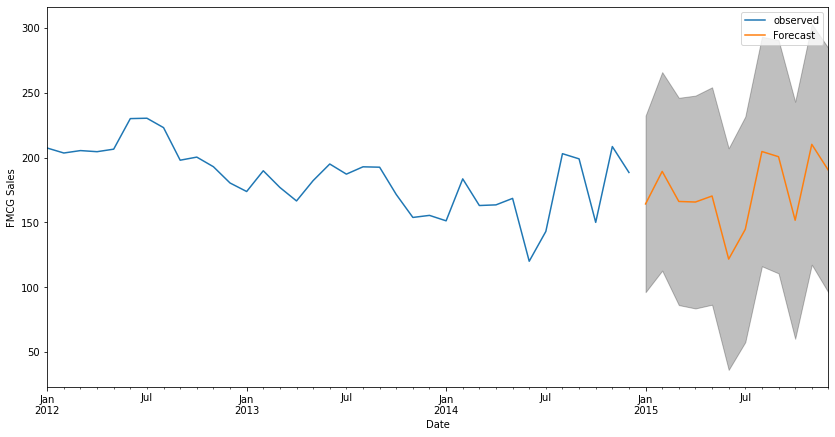

In [32]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('FMCG Sales')

plt.legend()
plt.show()

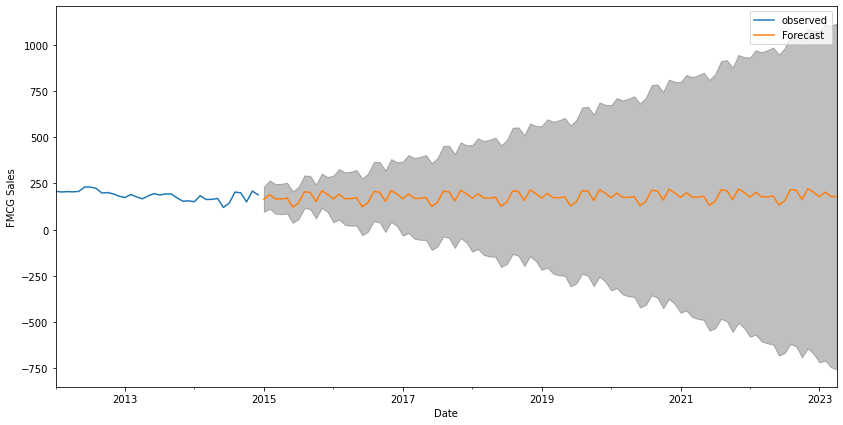

In [33]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('FMCG Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for FMCG makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of FMCG and drinks_and_food sales.

## Time Series comparison FMCG , Perishables and sales

### Data Processing

In [34]:
FMCG = train_raw.loc[train_raw['category_of_product'] == 'fast_moving_consumer_goods']
Perishables = train_raw.loc[train_raw['category_of_product'] == 'drinks_and_food']
Others = train_raw.loc[train_raw['category_of_product'] == 'others']



In [35]:
FMCG.shape, Perishables.shape, Others.shape

((229100, 7), (134300, 7), (31600, 7))

According to our data, there were way more number of sales from FMC goods than from Persihables over the years.

In [36]:
cols = ['product_identifier', 'department_identifier',
       'category_of_product', 'outlet', 'state']

FMCG = FMCG.drop(cols, axis=1)
Perishables = Perishables.drop(cols, axis=1)
Others = Others.drop(cols, axis=1)

FMCG = FMCG.sort_values('date')
Perishables = Perishables.sort_values('date')
Others = Others.sort_values('date')

FMCG = FMCG.groupby('date')['sales'].sum().reset_index()
Perishables = Perishables.groupby('date')['sales'].sum().reset_index()
Others = Others.groupby('date')['sales'].sum().reset_index()

Have a quick peek, perfect!

In [37]:
Perishables.head()

date  sales
0 2012-01-01    501
1 2012-01-02    519
2 2012-01-03    383
3 2012-01-04    507
4 2012-01-05    378

In [38]:
FMCG.head()

date  sales
0 2012-01-01    144
1 2012-01-02    172
2 2012-01-03    221
3 2012-01-04    277
4 2012-01-05    226

In [39]:
Others.head()

date  sales
0 2012-01-01      9
1 2012-01-02     41
2 2012-01-03     31
3 2012-01-04     29
4 2012-01-05     33

### Data exploration

We are going to compare two categories' sales in the same time period. This means combine two data frames into one and plot these two categories' time series into one plot.

In [40]:
FMCG = FMCG.set_index('date')
Perishables = Perishables.set_index('date')

y_FMCG = FMCG['sales'].resample('MS').mean()
y_Perishables = Perishables['sales'].resample('MS').mean()

FMCG = pd.DataFrame({'date':y_FMCG.index, 'sales':y_FMCG.values})
Perishables = pd.DataFrame({'date': y_Perishables.index, 'sales': y_Perishables.values})

store = FMCG.merge(Perishables, how='inner', on='date')
store.rename(columns={'sales_x': 'FMCG_sales', 'sales_y': 'Perishable_sales'}, inplace=True)

store.head()


date  FMCG_sales  Perishable_sales
0 2012-01-01  207.354839        439.741935
1 2012-02-01  203.517241        404.448276
2 2012-03-01  205.387097        377.451613
3 2012-04-01  204.533333        382.233333
4 2012-05-01  206.483871        425.741935

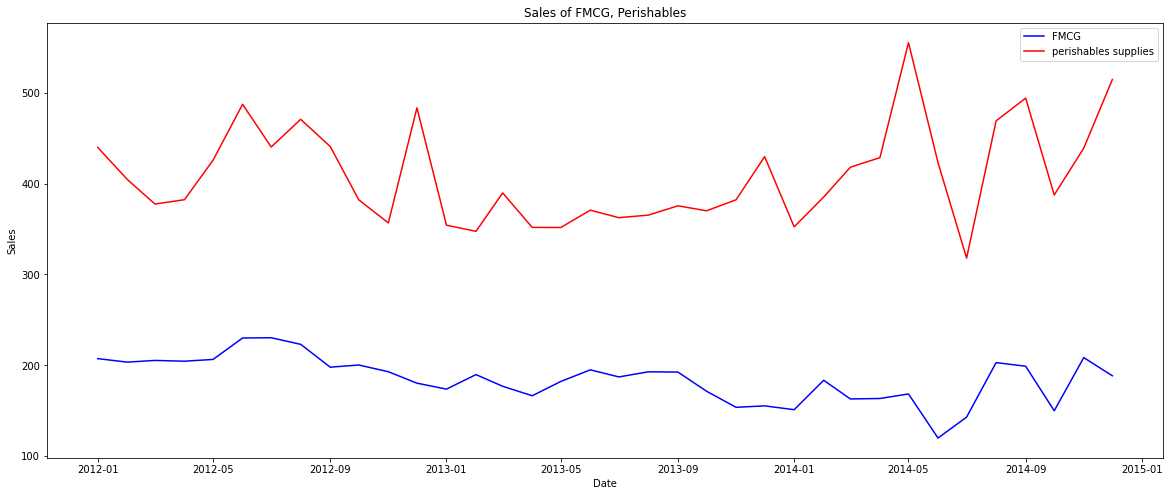

In [41]:
plt.figure(figsize=(20, 8))
plt.plot(store['date'], store['FMCG_sales'], 'b-', label = 'FMCG')
plt.plot(store['date'], store['Perishable_sales'], 'r-', label = 'perishables supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of FMCG, Perishables')
plt.legend();

We observe that sales of FMCG and Perishables do not share a similar seasonal pattern. Early of the year is the off season for both of the two categories. Average daily sales for perishable are higher than those of  FMCG in most of the months. It is understandable, as the value of perishable should be much higher than those of FMCG supplies.

## Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [45]:
from fbprophet import Prophet

FMCG = FMCG.rename(columns={'date': 'ds', 'sales': 'y'})
FMCG_model = Prophet(interval_width=0.95)
FMCG_model.fit(FMCG)

Perishables = Perishables.rename(columns={'date': 'ds', 'sales': 'y'})
Perishables_model = Prophet(interval_width=0.95)
Perishables_model.fit(Perishables)

Others = Perishables.rename(columns={'date': 'ds', 'sales': 'y'})
Others_model = Prophet(interval_width=0.95)
Others_model.fit(Others)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
FMCG_forecast = FMCG_model.make_future_dataframe(periods=36, freq='MS')
FMCG_forecast = FMCG_model.predict(FMCG_forecast)

Perishables_forecast = Perishables_model.make_future_dataframe(periods=36, freq='MS')
Perishables_forecast = Perishables_model.predict(Perishables_forecast)

Others_forecast = Others_model.make_future_dataframe(periods=36, freq='MS')
Others_forecast = Others_model.predict(Others_forecast)


<Figure size 1296x432 with 0 Axes>

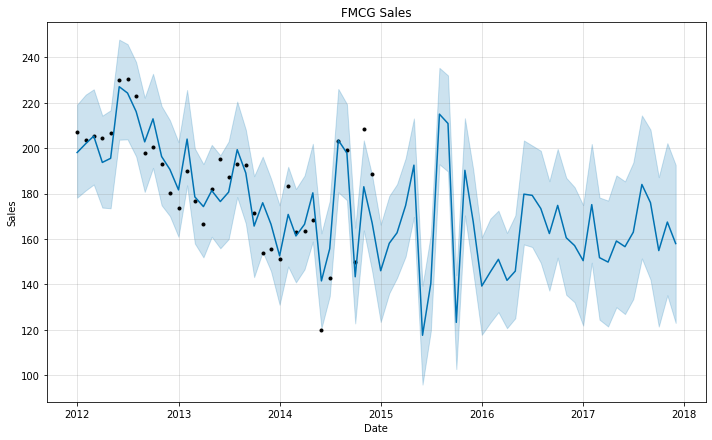

In [48]:
plt.figure(figsize=(18, 6))
FMCG_model.plot(FMCG_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('FMCG Sales');

<Figure size 1296x432 with 0 Axes>

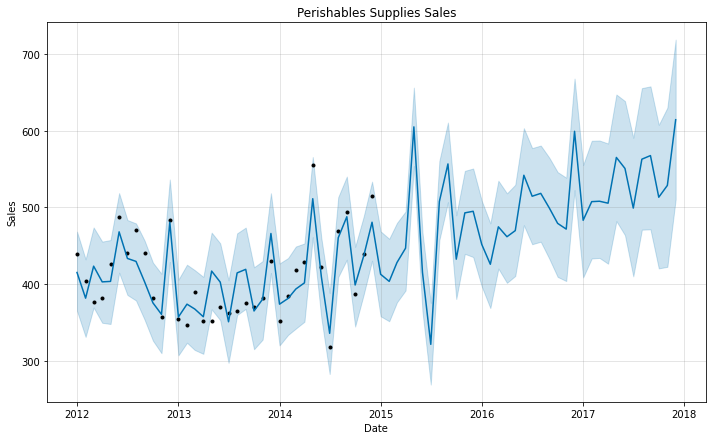

In [49]:
plt.figure(figsize=(18, 6))
Perishables_model.plot(Perishables_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Perishables Supplies Sales');

<Figure size 1296x432 with 0 Axes>

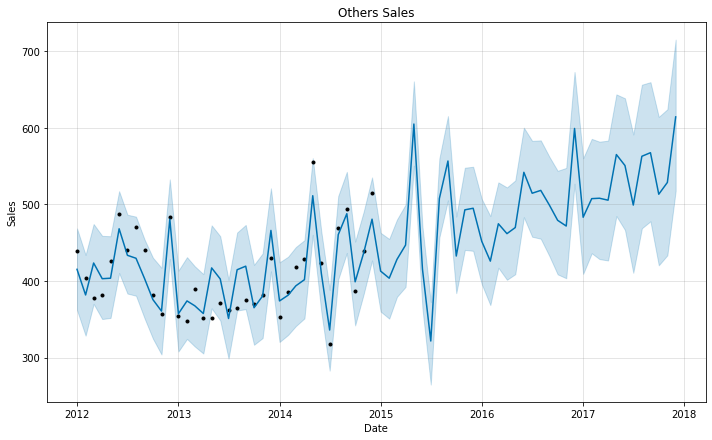

In [52]:
plt.figure(figsize=(18, 6))
Others_model.plot(Others_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Others Sales');

## Compare Forecasts

We already have the forecasts for three years for these three categories into the future. We will now join them together to compare their future forecasts.

In [61]:
FMCG_names = ['FMCG_%s' % column for column in FMCG_forecast.columns]
Perishables_names = ['Perishables_%s' % column for column in Perishables_forecast.columns]
Others_names = ['Others_%s' % column for column in Others_forecast.columns]

merge_FMCG_forecast = FMCG_forecast.copy()
merge_Perishables_forecast = Perishables_forecast.copy()
merge_Others_forecast = Others_forecast.copy()

merge_FMCG_forecast.columns = FMCG_names
merge_Perishables_forecast.columns = Perishables_names
merge_Others_forecast.columns = Others_names

forecast = pd.merge(merge_FMCG_forecast, merge_Others_forecast, how='inner', left_on='FMCG_ds', right_on='Others_ds')

forecast = forecast.rename(columns={'FMCG_ds': 'Date'}).drop('Others_ds', axis=1)

forecast.head()


Date  FMCG_trend  FMCG_yhat_lower  FMCG_yhat_upper  FMCG_trend_lower  \
0 2012-01-01  219.807068       178.180229       219.222448        219.807068   
1 2012-02-01  217.286037       181.376091       223.600908        217.286037   
2 2012-03-01  214.927654       183.990183       225.942214        214.927654   
3 2012-04-01  212.406623       173.819661       214.339202        212.406623   
4 2012-05-01  209.966916       173.524024       216.708232        209.966916   

   FMCG_trend_upper  FMCG_additive_terms  FMCG_additive_terms_lower  \
0        219.807068           -21.719077                 -21.719077   
1        217.286037           -15.299649                 -15.299649   
2        214.927654            -9.604367                  -9.604367   
3        212.406623           -18.681226                 -18.681226   
4        209.966916           -14.428992                 -14.428992   

   FMCG_additive_terms_upper  FMCG_yearly  ...  Others_additive_terms  \
0                 -21.719077   -21.719077  ...             -27.207407   
1                 -15.299649   -15.299649  ...             -56.263017   
2                  -9.604367    -9.604367  ...             -10.407481   
3                 -18.681226   -18.681226  ...             -26.451103   
4                 -14.428992   -14.428992  ...             -21.539262   

   Others_additive_terms_lower  Others_additive_terms_upper  Others_yearly  \
0                   -27.207407                   -27.207407     -27.207407   
1                   -56.263017                   -56.263017     -56.263017   
2                   -10.407481                   -10.407481     -10.407481   
3                   -26.451103                   -26.451103     -26.451103   
4                   -21.539262                   -21.539262     -21.539262   

   Others_yearly_lower  Others_yearly_upper  Others_multiplicative_terms  \
0           -27.207407           -27.207407                          0.0   
1           -56.263017           -56.263017                          0.0   
2           -10.407481           -10.407481                          0.0   
3           -26.451103           -26.451103                          0.0   
4           -21.539262           -21.539262                          0.0   

   Others_multiplicative_terms_lower  Others_multiplicative_terms_upper  \
0                                0.0                                0.0   
1                                0.0                                0.0   
2                                0.0                                0.0   
3                                0.0                                0.0   
4                                0.0                                0.0   

   Others_yhat  
0   415.265022  
1   381.781938  
2   423.495643  
3   403.024548  
4   403.651737  

[5 rows x 31 columns]

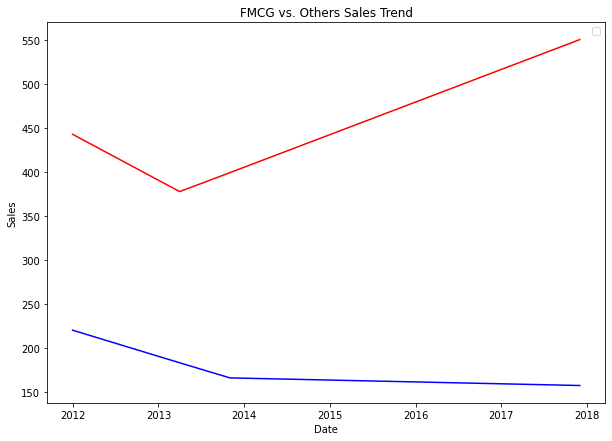

In [62]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['FMCG_trend'], 'b-')
plt.plot(forecast['Date'], forecast['Others_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('FMCG vs. Others Sales Trend');

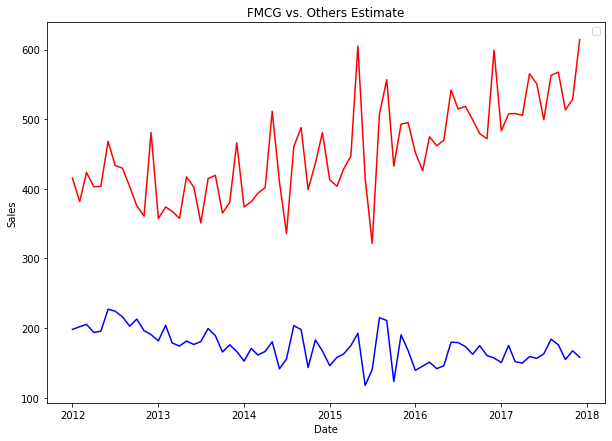

In [63]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['FMCG_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['Others_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('FMCG vs. Others Estimate');

## Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

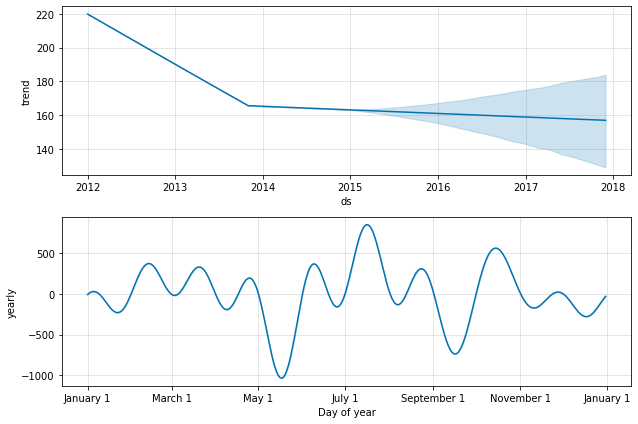

In [64]:
FMCG_model.plot_components(FMCG_forecast);

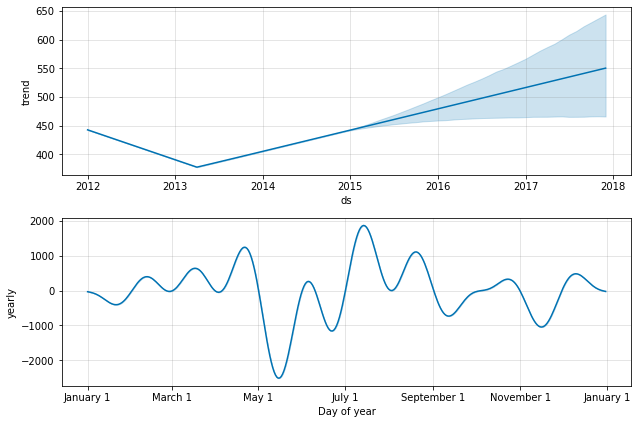

In [65]:
Perishables_model.plot_components(Perishables_forecast);

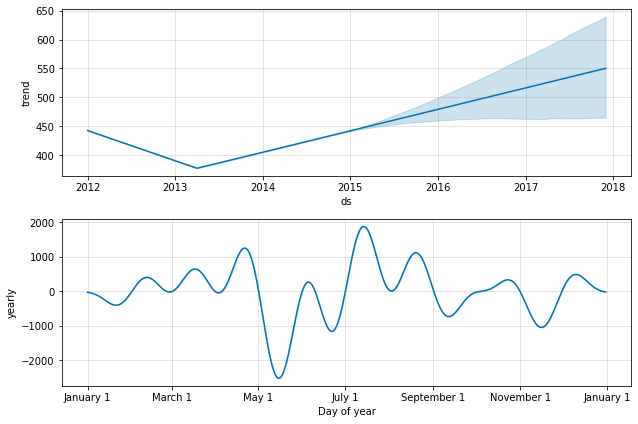

In [66]:
Others_model.plot_components(Others_forecast);

Import Statements

In [52]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
import warnings

## Data Preparation

Read train and test files

In [53]:
train_raw = pd.read_csv('train_data.csv')
test_raw = pd.read_csv('test_data.csv')
date_week = pd.read_csv('date_to_week_id_map.csv')
product_prices = pd.read_csv('product_prices.csv')

Check the shape of the input data

In [54]:
print(train_raw.shape)
print(test_raw.shape)

(395000, 7)
(15500, 7)


Add week data from date_to_week_id_map.csv to train data

In [55]:
train_raw = train_raw.assign(week_id=train_raw['date'].map(date_week.set_index('date')['week_id']))
test_raw = test_raw.assign(week_id=train_raw['date'].map(date_week.set_index('date')['week_id']))


Check the shape of the input data after adding week

In [56]:
print(train_raw.shape)
print(test_raw.shape)

(395000, 8)
(15500, 8)


Add sell_price data from product_prices.csv to train data

In [57]:
train_raw = train_raw.merge(product_prices, left_on=['product_identifier', 'outlet', 'week_id'], right_on=['product_identifier', 'outlet', 'week_id'])
test_raw = test_raw.merge(product_prices, left_on=['product_identifier', 'outlet', 'week_id'], right_on=['product_identifier', 'outlet', 'week_id'])


Reset index from input files

In [58]:
train_raw = train_raw.reset_index()
test_raw = test_raw.reset_index()
train_raw = train_raw.drop(['index', 'week_id'], axis=1)
test_raw = test_raw.drop(['index', 'week_id'], axis=1)

In [59]:
print(train_raw.shape)
print(test_raw.shape)

(395000, 8)
(15500, 8)


In [60]:
train_raw.head()

date  product_identifier  department_identifier category_of_product  \
0  2012-01-01                  74                     11              others   
1  2012-01-02                  74                     11              others   
2  2012-01-03                  74                     11              others   
3  2012-01-04                  74                     11              others   
4  2012-01-05                  74                     11              others   

   outlet        state  sales  sell_price  
0     111  Maharashtra      0        2.94  
1     111  Maharashtra      0        2.94  
2     111  Maharashtra      1        2.94  
3     111  Maharashtra      0        2.94  
4     111  Maharashtra      0        2.94

In [61]:
train_raw.tail()

date  product_identifier  department_identifier  \
394995  2014-02-24                3021                     33   
394996  2014-02-25                3021                     33   
394997  2014-02-26                3021                     33   
394998  2014-02-27                3021                     33   
394999  2014-02-28                3021                     33   

       category_of_product  outlet   state  sales  sell_price  
394995     drinks_and_food     333  Kerala      0        2.08  
394996     drinks_and_food     333  Kerala      0        2.08  
394997     drinks_and_food     333  Kerala      0        2.08  
394998     drinks_and_food     333  Kerala      0        2.08  
394999     drinks_and_food     333  Kerala      0        2.08

In [62]:
test_raw.head()

id        date  product_identifier  department_identifier  \
0     1  2014-03-01                  74                     11   
1   501  2014-03-02                  74                     11   
2  1001  2014-03-03                  74                     11   
3  1501  2014-03-04                  74                     11   
4  2001  2014-03-05                  74                     11   

  category_of_product  outlet        state  sell_price  
0              others     111  Maharashtra        2.94  
1              others     111  Maharashtra        2.94  
2              others     111  Maharashtra        2.94  
3              others     111  Maharashtra        2.94  
4              others     111  Maharashtra        2.94

In [63]:
test_raw.tail()

id        date  product_identifier  department_identifier  \
15495  15499  2014-03-31                3008                     33   
15496  14000  2014-03-28                3021                     33   
15497  14500  2014-03-29                3021                     33   
15498  15000  2014-03-30                3021                     33   
15499  15500  2014-03-31                3021                     33   

      category_of_product  outlet   state  sell_price  
15495     drinks_and_food     333  Kerala        1.98  
15496     drinks_and_food     333  Kerala        2.08  
15497     drinks_and_food     333  Kerala        2.08  
15498     drinks_and_food     333  Kerala        2.08  
15499     drinks_and_food     333  Kerala        2.08

In [64]:
train_raw.describe()

product_identifier  department_identifier         outlet  \
count       395000.000000          395000.000000  395000.000000   
mean          1509.960000              24.460000     211.200000   
std            809.799518               6.337863      91.161291   
min             74.000000              11.000000     111.000000   
25%            926.000000              21.000000     113.000000   
50%           1325.000000              22.000000     221.500000   
75%           1753.000000              31.000000     331.000000   
max           3021.000000              33.000000     333.000000   

               sales     sell_price  
count  395000.000000  395000.000000  
mean        1.228919       4.987644  
std         3.595266       3.874444  
min         0.000000       0.050000  
25%         0.000000       2.680000  
50%         0.000000       3.980000  
75%         1.000000       6.480000  
max       293.000000      44.360000

## Preprocessing

change date to datetime format - train data

In [65]:

print(train_raw.dtypes)
train_raw['date'] = pd.to_datetime(train_raw['date'], infer_datetime_format=True)
print('\n')
print(train_raw.dtypes)

date                      object
product_identifier         int64
department_identifier      int64
category_of_product       object
outlet                     int64
state                     object
sales                      int64
sell_price               float64
dtype: object


date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product              object
outlet                            int64
state                            object
sales                             int64
sell_price                      float64
dtype: object


change date to datetime format - test data

In [66]:

print(test_raw.dtypes)
test_raw['date'] = pd.to_datetime(test_raw['date'], infer_datetime_format=True)
print('\n')
print(test_raw.dtypes)

id                         int64
date                      object
product_identifier         int64
department_identifier      int64
category_of_product       object
outlet                     int64
state                     object
sell_price               float64
dtype: object


id                                int64
date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product              object
outlet                            int64
state                            object
sell_price                      float64
dtype: object


In [67]:
train_raw.head(2)

date  product_identifier  department_identifier category_of_product  \
0 2012-01-01                  74                     11              others   
1 2012-01-02                  74                     11              others   

   outlet        state  sales  sell_price  
0     111  Maharashtra      0        2.94  
1     111  Maharashtra      0        2.94

In [68]:
test_raw.head(2)

id       date  product_identifier  department_identifier  \
0    1 2014-03-01                  74                     11   
1  501 2014-03-02                  74                     11   

  category_of_product  outlet        state  sell_price  
0              others     111  Maharashtra        2.94  
1              others     111  Maharashtra        2.94

In [69]:
train_raw = train_raw.sort_values('date')
train_raw = train_raw.reset_index()
train_raw.drop('index', axis=1, inplace=True)
train_raw.head()

date  product_identifier  department_identifier  \
0 2012-01-01                  74                     11   
1 2012-01-01                2935                     33   
2 2012-01-01                2932                     33   
3 2012-01-01                1599                     22   
4 2012-01-01                2853                     33   

          category_of_product  outlet        state  sales  sell_price  
0                      others     111  Maharashtra      0        2.94  
1             drinks_and_food     222    Telangana     27        0.20  
2             drinks_and_food     222    Telangana      1        2.98  
3  fast_moving_consumer_goods     112  Maharashtra      0        6.94  
4             drinks_and_food     222    Telangana      7        3.98

In [70]:
test_data = test_raw.drop('id', axis=1)
test_data.head()

date  product_identifier  department_identifier category_of_product  \
0 2014-03-01                  74                     11              others   
1 2014-03-02                  74                     11              others   
2 2014-03-03                  74                     11              others   
3 2014-03-04                  74                     11              others   
4 2014-03-05                  74                     11              others   

   outlet        state  sell_price  
0     111  Maharashtra        2.94  
1     111  Maharashtra        2.94  
2     111  Maharashtra        2.94  
3     111  Maharashtra        2.94  
4     111  Maharashtra        2.94

In [71]:
train_raw.dtypes

date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product              object
outlet                            int64
state                            object
sales                             int64
sell_price                      float64
dtype: object

In [72]:
train_raw.nunique()

date                     790
product_identifier        50
department_identifier      6
category_of_product        3
outlet                    10
state                      3
sales                    126
sell_price               107
dtype: int64

Cast typing - Train data

In [73]:
train_data = train_raw
train_data['product_identifier'] = train_data['product_identifier'].astype('category')
train_data['department_identifier'] = train_data['department_identifier'].astype('category')
train_data['category_of_product'] = train_data['category_of_product'].astype('category')
train_data['outlet'] = train_data['outlet'].astype('category')
train_data['state'] = train_data['state'].astype('category')
train_data.dtypes

date                     datetime64[ns]
product_identifier             category
department_identifier          category
category_of_product            category
outlet                         category
state                          category
sales                             int64
sell_price                      float64
dtype: object

Categorical data encoding - Train data

In [74]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_data.iloc[:,1] = le.fit_transform(train_data.iloc[:,1])
train_data.iloc[:,2] = le.fit_transform(train_data.iloc[:,2])
train_data.iloc[:,3] = le.fit_transform(train_data.iloc[:,3])
train_data.iloc[:,4] = le.fit_transform(train_data.iloc[:,4])
train_data.iloc[:,5] = le.fit_transform(train_data.iloc[:,5])
train_data.dtypes

date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product               int64
outlet                            int64
state                             int64
sales                             int64
sell_price                      float64
dtype: object

In [75]:
test_data.dtypes

date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product              object
outlet                            int64
state                            object
sell_price                      float64
dtype: object

Cast typing - Test data

In [76]:
test_data['product_identifier'] = test_data['product_identifier'].astype('category')
test_data['department_identifier'] = test_data['department_identifier'].astype('category')
test_data['category_of_product'] = test_data['category_of_product'].astype('category')
test_data['outlet'] = test_data['outlet'].astype('category')
test_data['state'] = test_data['state'].astype('category')
test_data.dtypes


date                     datetime64[ns]
product_identifier             category
department_identifier          category
category_of_product            category
outlet                         category
state                          category
sell_price                      float64
dtype: object

Categorical data encoding - Train data

In [77]:
test_data.iloc[:,1] = le.fit_transform(test_data.iloc[:,1])
test_data.iloc[:,2] = le.fit_transform(test_data.iloc[:,2])
test_data.iloc[:,3] = le.fit_transform(test_data.iloc[:,3])
test_data.iloc[:,4] = le.fit_transform(test_data.iloc[:,4])
test_data.iloc[:,5] = le.fit_transform(test_data.iloc[:,5])
test_data.dtypes

date                     datetime64[ns]
product_identifier                int64
department_identifier             int64
category_of_product               int64
outlet                            int64
state                             int64
sell_price                      float64
dtype: object

In [78]:
X = train_data[['date', 'product_identifier', 'department_identifier', 'category_of_product', 'outlet', 'state', 'sell_price']]
y = train_data.iloc[:,6]


In [79]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(X["date"])
train_dataset['y']=y
train_dataset.head(2)

ds   y
0 2012-01-01   0
1 2012-01-01  27

## Modeling

In [80]:
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_dataset)

In [81]:
train_dataset['product_identifier'] = X['product_identifier']
train_dataset['department_identifier'] = X['department_identifier']
train_dataset['category_of_product'] = X['category_of_product']
train_dataset['outlet'] = X['outlet']
train_dataset['state'] = X['state']
train_dataset['sell_price'] = X['sell_price']

In [82]:
test_data['ds'] = test_data['date']
test_data.head()

date  product_identifier  department_identifier  category_of_product  \
0 2014-03-01                   0                      0                    2   
1 2014-03-02                   0                      0                    2   
2 2014-03-03                   0                      0                    2   
3 2014-03-04                   0                      0                    2   
4 2014-03-05                   0                      0                    2   

   outlet  state  sell_price         ds  
0       0      1        2.94 2014-03-01  
1       0      1        2.94 2014-03-02  
2       0      1        2.94 2014-03-03  
3       0      1        2.94 2014-03-04  
4       0      1        2.94 2014-03-05

In [83]:
cols = list(test_data.columns)
cols = [cols[-1]] + cols[:-1]
test_data = test_data[cols]

In [84]:
test_data = test_data.drop('date', axis=1)
test_data.head()

ds  product_identifier  department_identifier  category_of_product  \
0 2014-03-01                   0                      0                    2   
1 2014-03-02                   0                      0                    2   
2 2014-03-03                   0                      0                    2   
3 2014-03-04                   0                      0                    2   
4 2014-03-05                   0                      0                    2   

   outlet  state  sell_price  
0       0      1        2.94  
1       0      1        2.94  
2       0      1        2.94  
3       0      1        2.94  
4       0      1        2.94

In [85]:
#Additional Regressor
pro_regressor = Prophet(daily_seasonality=True)
pro_regressor.add_regressor('product_identifier')
pro_regressor.add_regressor('department_identifier')
pro_regressor.add_regressor('category_of_product')
pro_regressor.add_regressor('outlet')
pro_regressor.add_regressor('state')
pro_regressor.add_regressor('sell_price')

In [86]:
#Fitting for Train data
pro_regressor.fit(train_dataset)

## Focecasting

In [87]:
#forecast the data for Test data
forecast_data = pro_regressor.predict(test_data)

In [88]:
forecast_data

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0     2014-03-01  0.119429   -3.422836    5.568481     0.119429     0.119429   
1     2014-03-01  0.119429   -2.289529    6.790315     0.119429     0.119429   
2     2014-03-01  0.119429   -3.449307    5.386246     0.119429     0.119429   
3     2014-03-01  0.119429   -2.431345    6.130516     0.119429     0.119429   
4     2014-03-01  0.119429   -2.981702    6.077058     0.119429     0.119429   
...          ...       ...         ...         ...          ...          ...   
15495 2014-03-31  0.149318   -3.203126    6.031436     0.139971     0.158711   
15496 2014-03-31  0.149318   -4.411318    4.661822     0.139971     0.158711   
15497 2014-03-31  0.149318   -4.145561    4.904258     0.139971     0.158711   
15498 2014-03-31  0.149318   -3.513203    5.167621     0.139971     0.158711   
15499 2014-03-31  0.149318   -2.208035    6.572109     0.139971     0.158711   

       additive_terms  additive_terms_lower  additive_terms_upper  \
0            0.983226              0.983226              0.983226   
1            1.928532              1.928532              1.928532   
2            0.922499              0.922499              0.922499   
3            1.770483              1.770483              1.770483   
4            1.486483              1.486483              1.486483   
...               ...                   ...                   ...   
15495        1.487509              1.487509              1.487509   
15496       -0.434953             -0.434953             -0.434953   
15497        0.092467              0.092467              0.092467   
15498        0.594937              0.594937              0.594937   
15499        1.920993              1.920993              1.920993   

       category_of_product  ...    weekly  weekly_lower  weekly_upper  \
0                -2.725114  ...  0.314854      0.314854      0.314854   
1                 1.600464  ...  0.314854      0.314854      0.314854   
2                -0.562325  ...  0.314854      0.314854      0.314854   
3                 1.600464  ...  0.314854      0.314854      0.314854   
4                 1.600464  ...  0.314854      0.314854      0.314854   
...                    ...  ...       ...           ...           ...   
15495             1.600464  ... -0.062899     -0.062899     -0.062899   
15496            -0.562325  ... -0.062899     -0.062899     -0.062899   
15497            -0.562325  ... -0.062899     -0.062899     -0.062899   
15498            -0.562325  ... -0.062899     -0.062899     -0.062899   
15499             1.600464  ... -0.062899     -0.062899     -0.062899   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.227820     -0.227820     -0.227820                   0.0   
1     -0.227820     -0.227820     -0.227820                   0.0   
2     -0.227820     -0.227820     -0.227820                   0.0   
3     -0.227820     -0.227820     -0.227820                   0.0   
4     -0.227820     -0.227820     -0.227820                   0.0   
...         ...           ...           ...                   ...   
15495 -0.151012     -0.151012     -0.151012                   0.0   
15496 -0.151012     -0.151012     -0.151012                   0.0   
15497 -0.151012     -0.151012     -0.151012                   0.0   
15498 -0.151012     -0.151012     -0.151012                   0.0   
15499 -0.151012     -0.151012     -0.151012                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                             0.0                         0.0  1.102656  
1                             0.0                         0.0  2.047962  
2                             0.0                         0.0  1.041928  
3                             0.0                         0.0  1.889912  
4                             0.0                         0.0  1.605912  
...                           ...                         ...       ...  


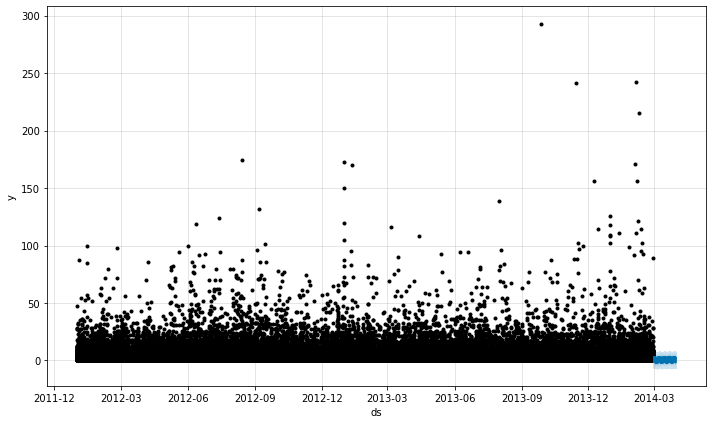

In [89]:
pro_regressor.plot(forecast_data);

In [90]:
predictions = forecast_data['yhat']
print(predictions.shape)
print(test_data.shape)

(15500,)
(15500, 7)


## Results

In [91]:
test_raw = pd.read_csv('test_data.csv')
id = pd.DataFrame(test_raw['id'], columns=['id'])
submission = pd.concat([id, predictions], axis=1).to_csv('output/submission_3.csv', index=None)